In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Đọc dữ liệu
data = pd.read_csv("../Dataset/data_integrated.csv")

# Chuyển cột 'date' sang định dạng thời gian
data['date'] = pd.to_datetime(data['date'])


In [44]:
# Tạo các đặc trưng từ cột date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['weekofyear'] = data['date'].dt.isocalendar().week


In [45]:
# Sắp xếp dữ liệu theo warehouse và thời gian
data = data.sort_values(by=['warehouse', 'date'])

# Tạo Lag Features và Rolling Mean cho mỗi kho hàng
def create_lag_features(df, lag_days=[7, 14], rolling_days=[7]):
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby('warehouse')['sales'].shift(lag)
    for roll in rolling_days:
        df[f'sales_roll_mean_{roll}'] = df.groupby('warehouse')['sales'].shift(1).rolling(roll).mean()
    return df

# Áp dụng hàm tạo đặc trưng
data = create_lag_features(data)


In [46]:
# Loại bỏ các dòng chứa giá trị NaN sau khi tạo lag features
data = data.dropna()

# Xóa các cột không cần thiết
data = data.drop(columns=['unique_id', 'product_unique_id', 'name'])


In [47]:
# Xác định ngày cắt giữa tập huấn luyện và kiểm tra
train_end_date = '2023-12-31'

# Chia dữ liệu
train_data = data[data['date'] <= train_end_date]
test_data = data[data['date'] > train_end_date]

# Tách X và y
X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']


### XGB

In [48]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng LabelEncoder cho các cột dạng object
for col in ['warehouse', 'category', 'holiday_name']:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Kiểm tra lại kiểu dữ liệu
print(data.dtypes)

# Chia lại dữ liệu
train_data = data[data['date'] <= train_end_date]
test_data = data[data['date'] > train_end_date]

X_train_xgb = train_data.drop(columns=['sales', 'date'])
y_train_xgb = train_data['sales']
X_test_xgb = test_data.drop(columns=['sales', 'date'])
y_test_xgb = test_data['sales']

# Huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Dự báo
y_pred_xgb = xgb_model.predict(X_test_xgb)


date                      datetime64[ns]
warehouse                          int32
total_orders                     float64
sales                            float64
sell_price_main                  float64
availability                     float64
max_discount                     float64
category                           int32
holiday_name                       int32
holiday                            int64
shops_closed                       int64
winter_school_holidays             int64
school_holidays                    int64
weekday                            int32
year                               int32
month                              int32
day                                int32
weekofyear                        UInt32
sales_lag_7                      float64
sales_lag_14                     float64
sales_roll_mean_7                float64
dtype: object


MAE (Mean Absolute Error): 69.21754666565684
RMSE (Root Mean Squared Error): 157.38510250895757


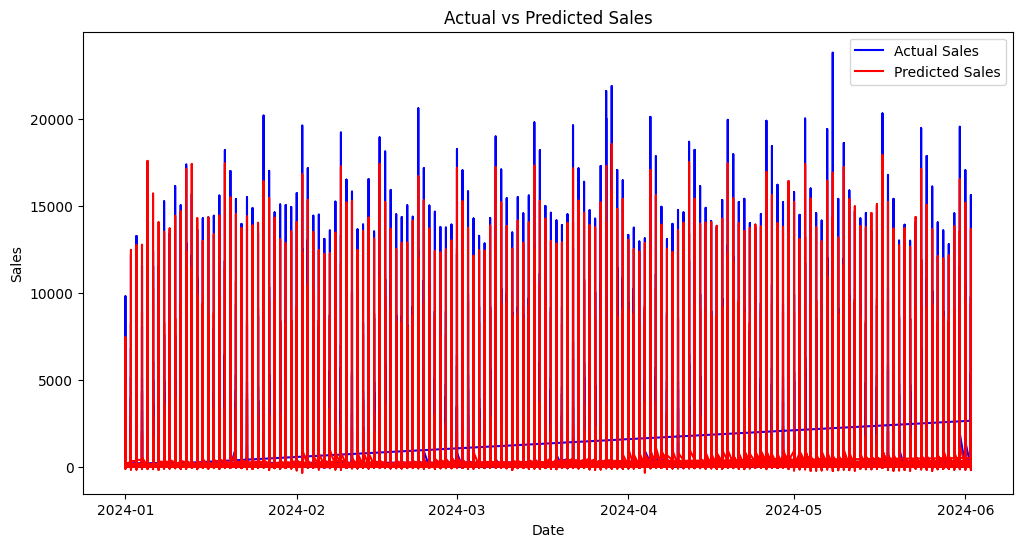

In [49]:
# Tính các chỉ số đánh giá
mae = mean_absolute_error(y_test_xgb , y_pred_xgb )
rmse = np.sqrt(mean_squared_error(y_test_xgb , y_pred_xgb ))

print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")

# Vẽ biểu đồ so sánh kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test_xgb , label='Actual Sales', color='blue')
plt.plot(test_data['date'], y_pred_xgb , label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()


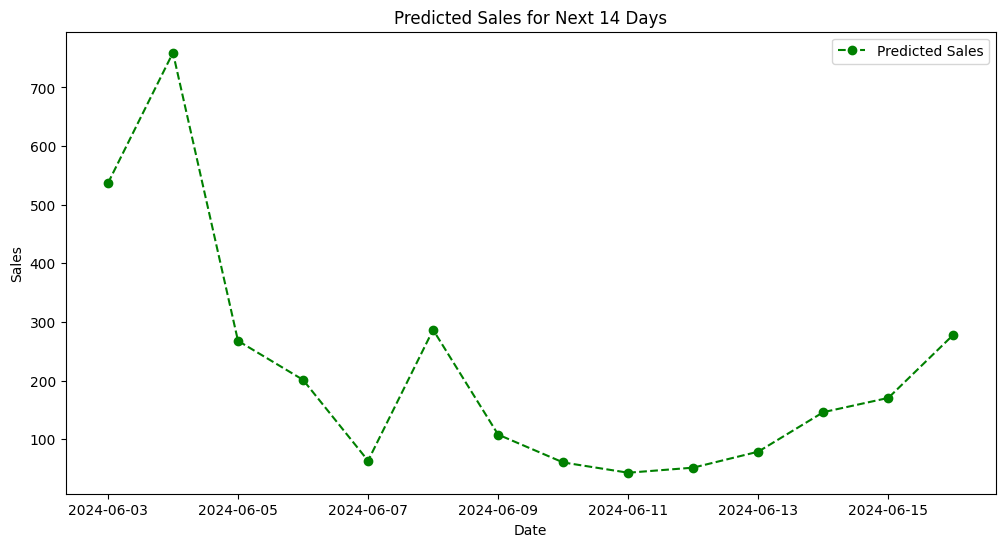

In [50]:
# Chuẩn bị dữ liệu đầu vào cho 14 ngày tiếp theo
future_dates = pd.date_range(test_data['date'].max() + pd.Timedelta(days=1), periods=14)
future_df = test_data.tail(14).copy()
future_df['date'] = future_dates

# Tạo lag features cho 14 ngày tiếp theo
future_df = create_lag_features(future_df)

# Dự báo
future_predictions = xgb_model.predict(future_df.drop(columns=['sales', 'date']))

# Hiển thị kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='--', color='green', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted Sales for Next 14 Days')
plt.legend()
plt.show()


### LIGHTGBM

In [51]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng LabelEncoder cho các cột dạng object
for col in ['warehouse', 'category', 'holiday_name']:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Kiểm tra lại kiểu dữ liệu
print(data.dtypes)

# Chia lại dữ liệu
train_data = data[data['date'] <= train_end_date]
test_data = data[data['date'] > train_end_date]

X_train_lgb = train_data.drop(columns=['sales', 'date'])
y_train_lgb= train_data['sales']
X_test_lgb = test_data.drop(columns=['sales', 'date'])
y_test_lgb = test_data['sales']

# Huấn luyện mô hình XGBoost
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

lgb_model.fit(X_train_lgb, y_train_lgb)

# Dự báo
y_pred_lgb = lgb_model.predict(X_test_lgb)


date                      datetime64[ns]
warehouse                          int32
total_orders                     float64
sales                            float64
sell_price_main                  float64
availability                     float64
max_discount                     float64
category                           int32
holiday_name                       int32
holiday                            int64
shops_closed                       int64
winter_school_holidays             int64
school_holidays                    int64
weekday                            int32
year                               int32
month                              int32
day                                int32
weekofyear                        UInt32
sales_lag_7                      float64
sales_lag_14                     float64
sales_roll_mean_7                float64
dtype: object
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=

Mean Absolute Error (MAE): 71.47987572531099
Root Mean Squared Error (RMSE): 159.6953413608026


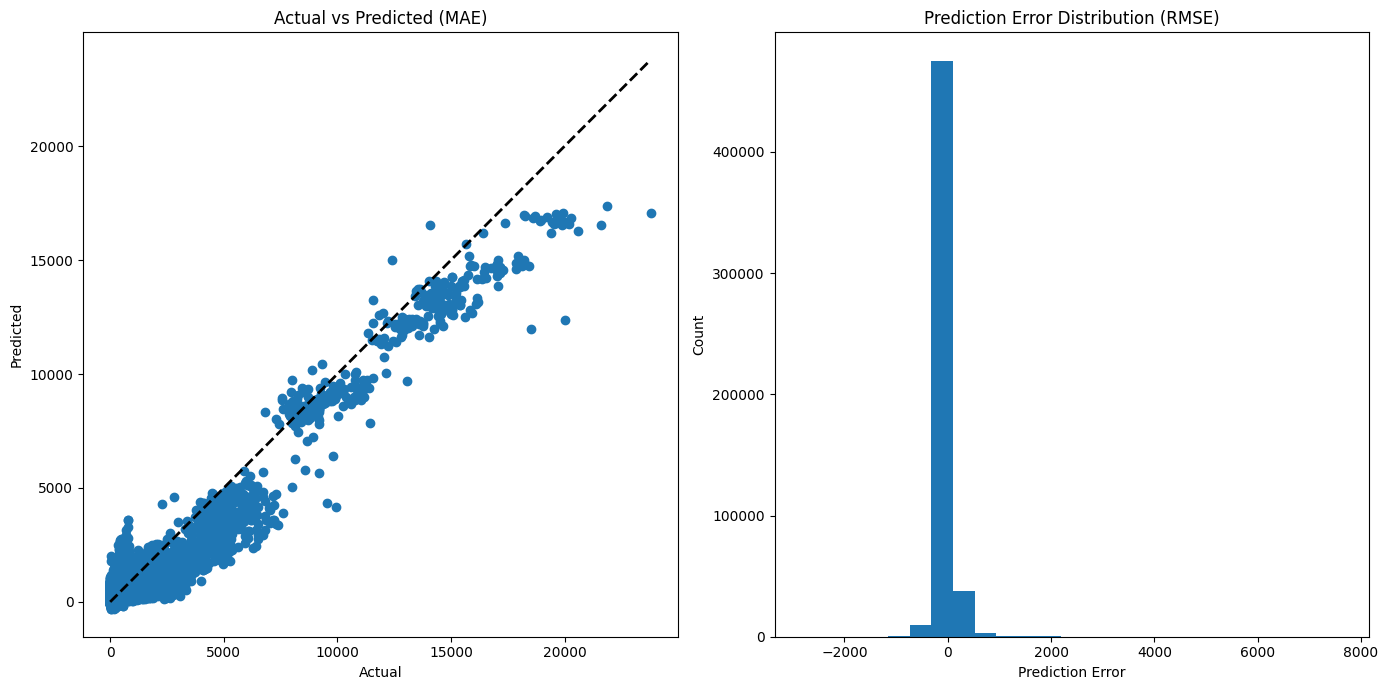

In [52]:
# Đánh giá mô hình
mae = mean_absolute_error(y_test_lgb, y_pred_lgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Biểu đồ MAE
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (MAE)')

# Biểu đồ RMSE
plt.subplot(1, 2, 2)
errors = y_test - y_pred_lgb
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution (RMSE)')

plt.tight_layout()
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


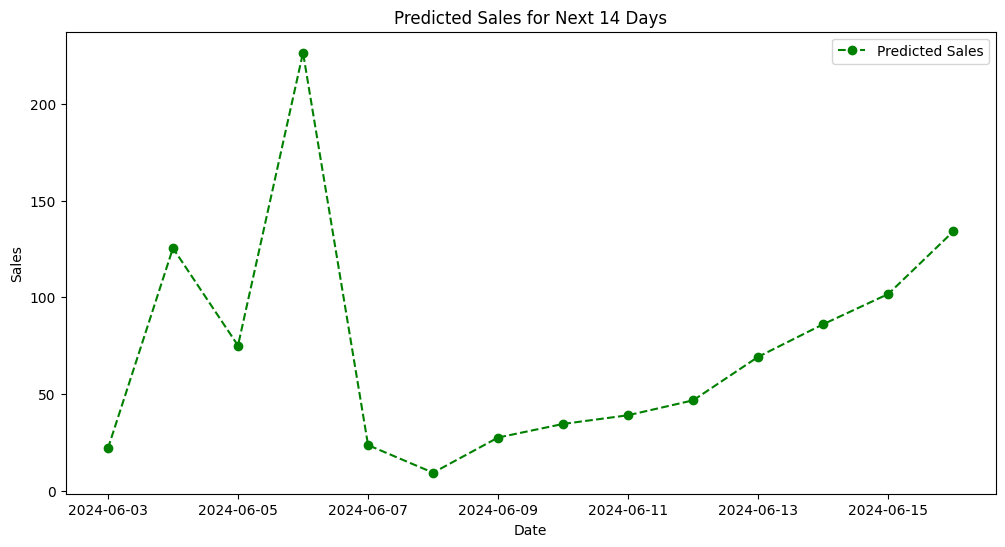

In [53]:
# Chuẩn bị dữ liệu đầu vào cho 14 ngày tiếp theo
future_dates = pd.date_range(test_data['date'].max() + pd.Timedelta(days=1), periods=14)
future_df = test_data.tail(14).copy()
future_df['date'] = future_dates

# Tạo lag features cho 14 ngày tiếp theo
future_df = create_lag_features(future_df)

# Dự báo
future_predictions = lgb_model.predict(future_df.drop(columns=['sales', 'date']))

# Hiển thị kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='--', color='green', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted Sales for Next 14 Days')
plt.legend()
plt.show()


### LSTM 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
label_encoder = LabelEncoder()

# Áp dụng LabelEncoder cho các cột dạng object
for col in ['warehouse', 'category', 'holiday_name']:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Kiểm tra lại kiểu dữ liệu
print(data.dtypes)
train_data = data[data['date'] <= train_end_date]
test_data = data[data['date'] > train_end_date]

X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Example sequence length
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_length)

# Step 5: Build and Train LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2)


In [ ]:
# Step 6: Evaluate the Model
y_pred_seq = model.predict(X_test_seq)
mae = mean_absolute_error(y_test_seq, y_pred_seq)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 7: Plot Results
plt.figure(figsize=(14, 7))

# Biểu đồ MAE
plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_seq)
plt.plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (MAE)')

# Biểu đồ RMSE
plt.subplot(1, 2, 2)
errors = y_test_seq - y_pred_seq
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution (RMSE)')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare Input Data for the Next 14 Days
future_dates = pd.date_range(test_data['date'].max() + pd.Timedelta(days=1), periods=14)
future_df = test_data.tail(seq_length).copy()
future_df['date'] = future_dates

# Normalize the future data
future_df_scaled = scaler.transform(future_df.drop(columns=['sales', 'date']))

# Create sequences for future predictions
X_future_seq = []
for i in range(14):
    X_future_seq.append(future_df_scaled[i:i+seq_length])
X_future_seq = np.array(X_future_seq)

# Make Predictions Using the LSTM Model
future_predictions = model.predict(X_future_seq)

# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='--', color='green', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted Sales for Next 14 Days')
plt.legend()
plt.show()